# File structure

This project assumes the following initial file structure:

```
.\main                               
|   Preliminary data analysis.ipynb  
|   ...                              
|                                    
\---data                             
    \---olympic_sw_1896_2022         
            olympic_athletes.csv     
            olympic_hosts.csv        
            olympic_medals.csv       
            olympic_results.csv      
            olympic_results.pkl      
            ...                      
```

# Modules

## Imports

In [1]:
import os
import types

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources
import seaborn as sns

## Versions

The current module versions in use are as follows:

In [2]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

pd.DataFrame(requirements, columns=["Module", "Version"])

,Module,Version
0,matplotlib,3.8.4
1,numpy,1.26.4
2,pandas,2.2.2
3,seaborn,0.13.2


# Global variables

The following global variables are used throughout the entirety of the methodology section.

In [3]:
DATA_PATH = "./data"
OLYMPIC_DATA_PATH = os.path.join(DATA_PATH, "olympic_sw_1896_2022")

# Preliminary data analysis

In this section, we embark on a foundational exploration of our dataset to glean essential insights that underpin our research objectives. We outline the dataset's key attributes, including its size, composition, and structure, while examining descriptive statistics to uncover central tendencies and distributions.

## Data import

In [4]:
athletesData = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_athletes.csv"))
medalsData = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_medals.csv"))
hostsData = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_hosts.csv"))
resultsData = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_results.csv"))

## Visualization

### Athletes

In [5]:
athletesData.head()

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio
0,https://olympics.com/en/athletes/cooper-woods-...,Cooper WOODS-TOPALOVIC,1,Beijing 2022,2000.0,NaN,NaN
1,https://olympics.com/en/athletes/elofsson,Felix ELOFSSON,2,PyeongChang 2018,1995.0,NaN,NaN
2,https://olympics.com/en/athletes/dylan-walczyk,Dylan WALCZYK,1,Beijing 2022,1993.0,NaN,NaN
3,https://olympics.com/en/athletes/olli-penttala,Olli PENTTALA,1,Beijing 2022,1995.0,NaN,NaN
4,https://olympics.com/en/athletes/reikherd,Dmitriy REIKHERD,1,Beijing 2022,1989.0,NaN,NaN


In [6]:
athletesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75904 entries, 0 to 75903
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   athlete_url           75904 non-null  object 
 1   athlete_full_name     75904 non-null  object 
 2   games_participations  75904 non-null  int64  
 3   first_game            75882 non-null  object 
 4   athlete_year_birth    73448 non-null  float64
 5   athlete_medals        15352 non-null  object 
 6   bio                   22842 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.1+ MB


In [7]:
athletesData.describe(include=np.number)

,games_participations,athlete_year_birth
count,75904.000000,73448.000000
mean,1.535874,1961.619377
std,0.854563,28.129576
min,0.000000,1836.000000
25%,1.000000,1946.000000
50%,1.000000,1968.000000
75%,2.000000,1983.000000
max,10.000000,2009.000000


In [8]:
athletesData.describe(include=object)

,athlete_url,athlete_full_name,first_game,athlete_medals,bio
count,75904,75904,75882,15352,22842
unique,75900,75480,53,170,22530
top,https://olympics.com/en/athletes/mariana-pajon,Ivan IVANOV,Rio 2016,\n\n\n1\n\nB\n\n,\n\n\nPersonal Best: Mar – unknown.\n\n\n\n\n\n
freq,2,4,4111,4209,110


The following code converts the `athlete_year_birth` column to the `Int64` data type, which is a pandas-specific integer type that supports nullable values. This ensures that the column contains integer values while allowing for `NaN` entries, providing better consistency for numerical operations involving birth years.

In [9]:
athletesData["athlete_year_birth"] = athletesData["athlete_year_birth"].astype("Int64")

The following code extracts information from the `first_game` column into two new columns, `first_game_host_city` and `first_game_year`, using a regular expression. The `.str.extract()` method is used with the regex pattern `r"^(.+?)\s(\d+?)$"` to capture the host city and the year separately. The pattern `^(.+?)\s(\d+?)$` matches the city name (which can contain spaces) followed by a space and a four-digit year, ensuring that both parts are properly captured. This allows us to split the `first_game` data into distinct columns for easier analysis.

In [10]:
athletesData[["first_game_city", "first_game_year"]] = athletesData[
    "first_game"
].str.extract(r"^(.+?)\s(\d+?)$")

athletesData["first_game_year"] = athletesData["first_game_year"].astype("Int64")

The following code extracts medal information from the `athlete_medals` column, converts it into structured medal counts, and stores these in new columns. First, the regex `.str.findall()` is used to extract medal pairs (number and type) from each string into the `medal_tuples` column. Next, a helper function `count_medals()` is defined to count specific medal types (`G`, `S`, `B`) in each list of tuples. This function is applied to create `bronze_count`, `silver_count`, and `gold_count` columns, representing the count of each medal type. Finally, a `total_medals` column is created by calculating the sum of the three newly created columns.

In [11]:
athletesData["medal_tuples"] = athletesData["athlete_medals"].str.findall(
    r"\n*(\d+)\n*([GSB])\n*"
)

In [12]:
def count_medals(medal_list, medal_type):
    if not isinstance(medal_list, list):
        return 0
    return sum(int(count) for count, medal in medal_list if medal == medal_type)


medal_types = ["B", "S", "G"]
athletesData["bronze_count"] = athletesData["medal_tuples"].apply(
    lambda x: count_medals(x, medal_types[0])
)
athletesData["silver_count"] = athletesData["medal_tuples"].apply(
    lambda x: count_medals(x, medal_types[1])
)
athletesData["gold_count"] = athletesData["medal_tuples"].apply(
    lambda x: count_medals(x, medal_types[2])
)

athletesData["total_medals"] = athletesData[
    ["bronze_count", "silver_count", "gold_count"]
].sum(axis=1)

Here, we remove information that is not pertinent for the present analysis.

In [13]:
athletesData = athletesData.drop(
    ["first_game", "athlete_url", "bio", "athlete_medals", "medal_tuples"], axis=1
)

Finally, we visualize again, some preliminary informations of the entries of the resulting data frame.

In [14]:
athletesData.head()

,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_year,bronze_count,silver_count,gold_count,total_medals
0,Cooper WOODS-TOPALOVIC,1,2000,Beijing,2022,0,0,0,0
1,Felix ELOFSSON,2,1995,PyeongChang,2018,0,0,0,0
2,Dylan WALCZYK,1,1993,Beijing,2022,0,0,0,0
3,Olli PENTTALA,1,1995,Beijing,2022,0,0,0,0
4,Dmitriy REIKHERD,1,1989,Beijing,2022,0,0,0,0


In [15]:
athletesData.describe(include=np.number)

,games_participations,athlete_year_birth,first_game_year,bronze_count,silver_count,gold_count,total_medals
count,75904.000000,73448.0,75882.0,75904.000000,75904.000000,75904.000000,75904.000000
mean,1.535874,1961.619377,1984.765742,0.109889,0.105844,0.109994,0.325727
std,0.854563,28.129576,28.683834,0.369809,0.380472,0.458560,0.851044
min,0.000000,1836.0,1896.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1946.0,1968.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1968.0,1992.0,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1983.0,2008.0,0.000000,0.000000,0.000000,0.000000
max,10.000000,2009.0,2022.0,6.000000,6.000000,23.000000,28.000000


In [16]:
athletesData.describe(include=object)

,athlete_full_name,first_game_city
count,75904,75882
unique,75480,43
top,Ivan IVANOV,London
freq,4,6113


#### Inconsistencies

Let's first take a look at the time stamps of the olympics as compared to athletes' ages.

In [17]:
game_years = pd.Series(pd.unique(athletesData["first_game_year"].dropna())).sort_values(
    ascending=True
)

boxDataBirth = []
boxDataAge = []
for game_year in game_years:
    year_births = athletesData[athletesData["first_game_year"] == game_year][
        "athlete_year_birth"
    ].dropna()
    boxDataBirth.append(year_births)
    boxDataAge.append(game_year - year_births)

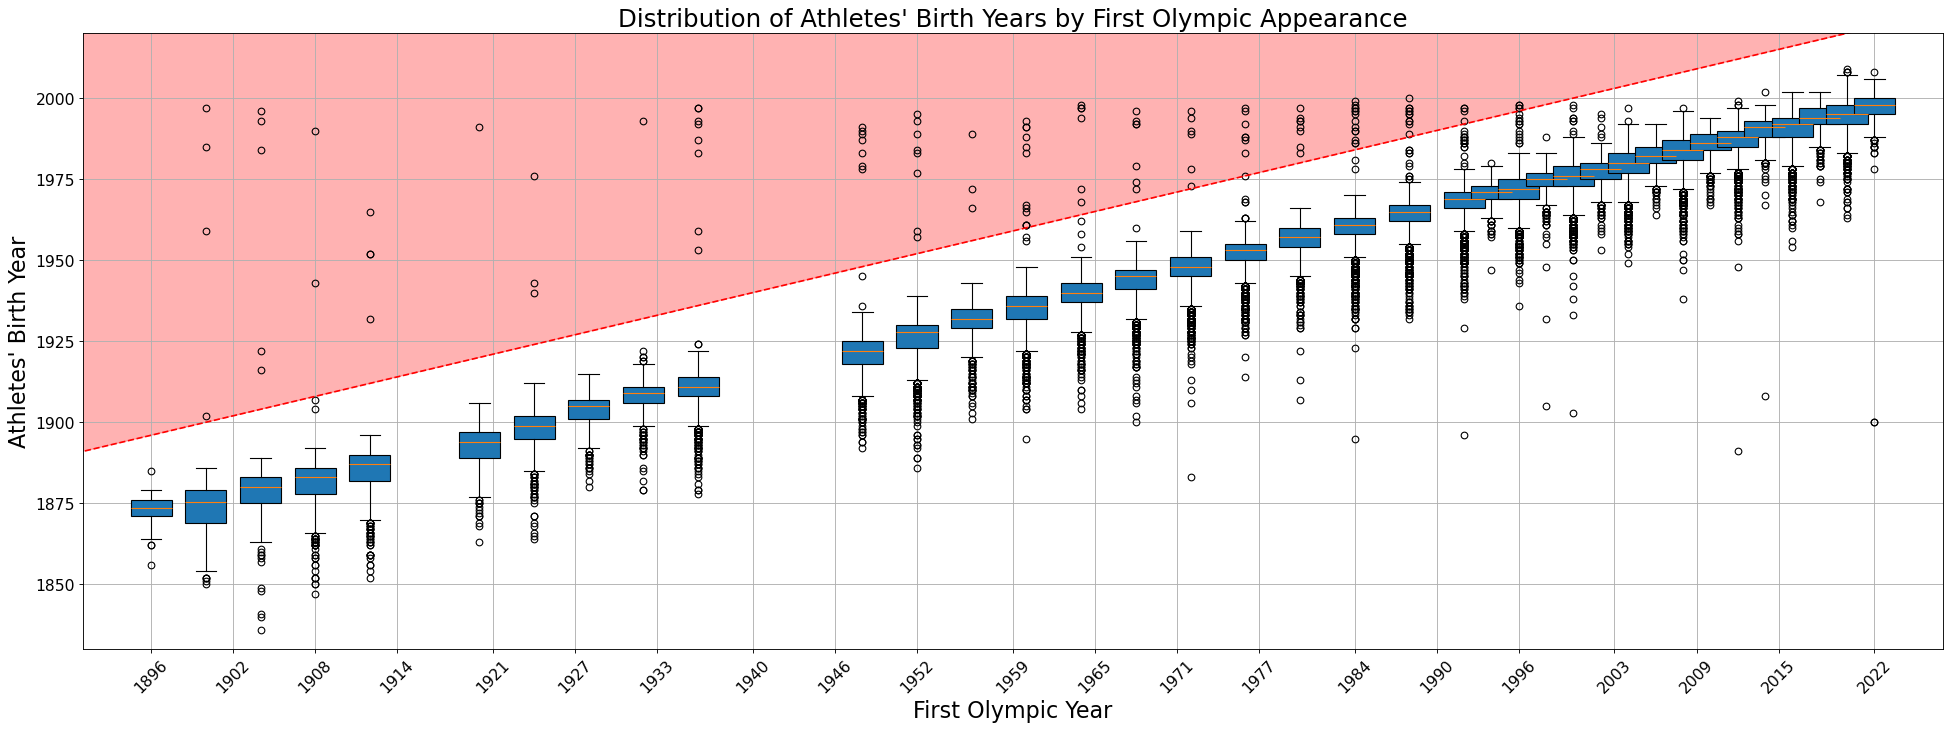

In [18]:
plt.figure(figsize=(30, 10), dpi=80)

plt.boxplot(
    boxDataBirth,
    positions=game_years,
    widths=[3] * len(game_years),
    patch_artist=True,
    manage_ticks=False,
)

lineData = np.arange(min(game_years) / 1.1, 1.1 * max(game_years))
plt.plot(lineData, lineData, linestyle="--", c="red")
plt.fill_between(x=lineData, y1=lineData, y2=2040, alpha=0.3, color="red")

# Decoration
plt.title(
    "Distribution of Athletes' Birth Years by First Olympic Appearance", fontsize=22
)
plt.xlabel("First Olympic Year", fontsize=20)
plt.xticks(
    ticks=np.linspace(min(game_years), max(game_years), num=21, dtype=int),
    rotation=45,
    fontsize=14,
)
plt.xlim(min(game_years) - 5, max(game_years) + 5)
plt.yticks(fontsize=14)
plt.ylabel("Athletes' Birth Year", fontsize=20)
plt.ylim(1830, 2020)
plt.grid()
plt.show()

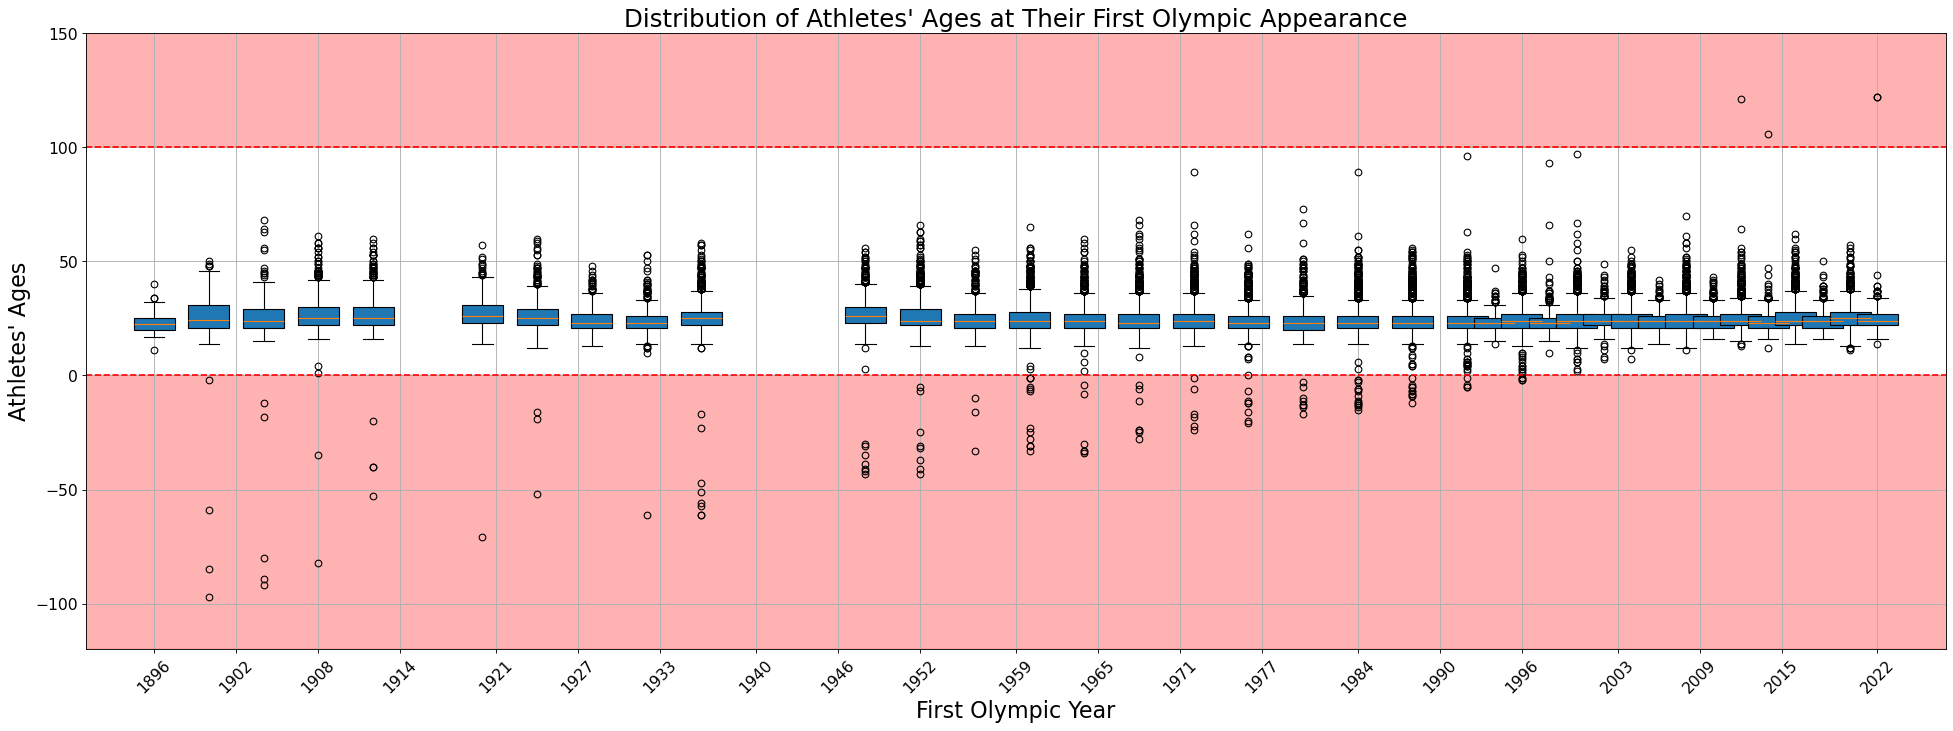

In [19]:
plt.figure(figsize=(30, 10), dpi=80)


plt.boxplot(
    boxDataAge,
    positions=game_years,
    widths=[3] * len(game_years),
    patch_artist=True,
    manage_ticks=False,
)

lineData = np.arange(min(game_years) / 2, 2 * max(game_years))
plt.axhline(0, linestyle="--", c="red")
plt.fill_between(x=lineData, y1=0, y2=-120, alpha=0.3, color="red")

plt.axhline(100, linestyle="--", c="red")
plt.fill_between(x=lineData, y1=100, y2=150, alpha=0.3, color="red")

# Decoration
plt.title("Distribution of Athletes' Ages at Their First Olympic Appearance", fontsize=22)
plt.xlabel("First Olympic Year", fontsize=20)
plt.xticks(
    ticks=np.linspace(min(game_years), max(game_years), num=21, dtype=int),
    rotation=45,
    fontsize=14,
)
plt.xlim(min(game_years) - 5, max(game_years) + 5)
plt.yticks(fontsize=14)
plt.ylabel("Athletes' Ages", fontsize=20)
plt.ylim(-120, 150)
plt.grid()
plt.show()

In [20]:
ageAtFirstOlympiad = (
    athletesData["first_game_year"] - athletesData["athlete_year_birth"]
)
tooYoungOldOlympic = athletesData[
    (ageAtFirstOlympiad <= 0) | (100 <= ageAtFirstOlympiad)
]

In [21]:
print(f"We discovered at least {len(tooYoungOldOlympic)} inconsistencies!")

We discovered at least 130 inconsistencies!


Let's now look at the athletes' names.

In [22]:
print(np.sort(pd.unique(athletesData["athlete_full_name"]))[:10])

[' DENI DENI' '. DENI' '. PRIYANKA' '. RAHUL' 'A Baser WASIQI' 'A J HURT'
 'A-Aziz Hassan JALOOF' 'A. DARNIS' 'A. Germaine GOLDING'
 'A. Linger ANDREAS LINGER']


In [23]:
countsDict = athletesData["athlete_full_name"].value_counts().to_dict()

repeatedNames = athletesData.assign(
    frequency=athletesData.apply(lambda x: countsDict[x["athlete_full_name"]], axis=1)
)

repeatedNames = (
    repeatedNames[repeatedNames["frequency"] > 1]
    .sort_values(by=["frequency", "athlete_full_name"], ascending=[False, True])
    .drop("frequency", axis=1)
)

In [24]:
repeatedNames.head()

,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_year,bronze_count,silver_count,gold_count,total_medals
28156,Francisco SANCHEZ,2,1976,Atlanta,1996,0,0,0,0
44334,Francisco SANCHEZ,1,1958,Moscow,1980,0,0,0,0
47128,Francisco SANCHEZ,1,1956,Montreal,1976,0,0,0,0
72475,Francisco SANCHEZ,3,1965,Seoul,1988,0,0,1,1
15863,Hao WANG,3,1983,Athens,2004,0,3,2,5


In [25]:
print(f"We discovered at least {len(repeatedNames)} inconsistencies!")

We discovered at least 800 inconsistencies!
